In [1]:
from qdtuner import QuantumDotFET, qc, FET_DataAnalyzer, inference
# !python -m qcodes.monitor.monitor

DA = FET_DataAnalyzer('../fet_tuner_config.yaml')

# Connect to Tuner Class

In [2]:
QD_FET_Tuner = QuantumDotFET(
    device_config='../device_config.yml',
    setup_config='../setup_config.yaml',
    tuner_config='../fet_tuner_config.yaml',
    station_config='../station_config.yaml',
    save_dir='C:\\Users\\coher\\Desktop\\Andrija'
)

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/qcodes/station.py:483: ValidationWarning: Additional properties are not allowed ('step=1.0e-3' was unexpected)

Failed validating 'additionalProperties' in schema['properties']['instruments']['patternProperties']['^\\w+$']['properties']['add_parameters']['patternProperties']['^(\\w+)(\\.\\w+)*$']:
    {'additionalProperties': False,
     'properties': {'initial_value': {},
                    'inter_delay': {'type': 'number'},
                    'label': {'type': 'string'},
                    'limits': {'additionalItems': False,
                               'items': [{'type': 'number'},
                                         {'type': 'number'}],
                               'maxItems': 2,
                               'minItems': 2,
                               'type': ['array', 'string']},
                    'monitor': {'type': 'boolean'},
                    'offset': {'type': 'number'},
             

Connecting to station ... 



KeyboardInterrupt



In [ ]:
# monitor = qc.Monitor(
#     QD_FET_Tuner.drain_volt, 
#     QD_FET_Tuner.voltage_source.S, 
#     QD_FET_Tuner.voltage_source.STL,
#     QD_FET_Tuner.voltage_source.LB,
#     QD_FET_Tuner.voltage_source.P,
#     QD_FET_Tuner.voltage_source.RB,
#     QD_FET_Tuner.voltage_source.STR
#     )
# monitor.show()

# 0. Bias Device 

In [ ]:
QD_FET_Tuner.bias_ohmic(
    ohmic='S', 
    V=0.005
) 

# 1. Turn On Device

In [ ]:
QD_FET_Tuner.turn_on(
    minV=0, 
    maxV=None,
    dV=0.05
)

# 2. Pinch Off Gate(s)

In [ ]:
QD_FET_Tuner.pinch_off(
    minV=None, 
    maxV=None, 
    dV=0.05,
    voltage_configuration={}
)

# 3. Barrier Barrier Sweep

In [ ]:
df, current_axes = QD_FET_Tuner.sweep_barriers(
    B1='LB', 
    B2='RB', 
    B1_bounds=(-2,-1),
    B2_bounds=(-1.25,-1),
    dV=0.05,
    voltage_configuration={},
    extract_bias_point=True
)

### 3.1 Extract Bias Point 

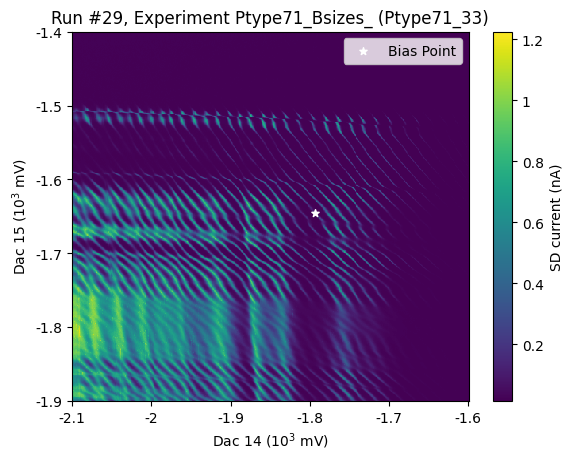

In [2]:
db_file = "/Users/andrijapaurevic/Desktop/db_20240517.db"

runID_BB = 29
# runID_CD = 46
import qcodes as qc
import sys, os
import matplotlib.pyplot as plt 

qc.dataset.initialise_or_create_database_at(db_file)

dataset = qc.dataset.load_by_id(runID_BB)
axes, cbar = qc.dataset.plot_dataset(dataset)
current_axes = axes[0]
df = dataset.to_pandas_dataframe().reset_index()
df.iloc[:,-1] = df.iloc[:,-1].subtract(0).mul(1.0e9) # sensitivity
current_axes.scatter([-1793.8877755510998],[-1645.991983967935], marker='*', s=30, c='w', label='Bias Point')
current_axes.legend(loc='best')

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1677571749046/work/aten/src/ATen/native/TensorShape.cpp:3489.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/src/inference.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours = np.subtract(contours, 1)


Suggested voltage window: {'dac15': (-1867.93587174349, -1409.01803607214), 'dac14': (-1887.5751503006, -1642.08416833667)}
Suggested bias point: {'dac15': -1645.991983967935, 'dac14': -1828.957915831665}


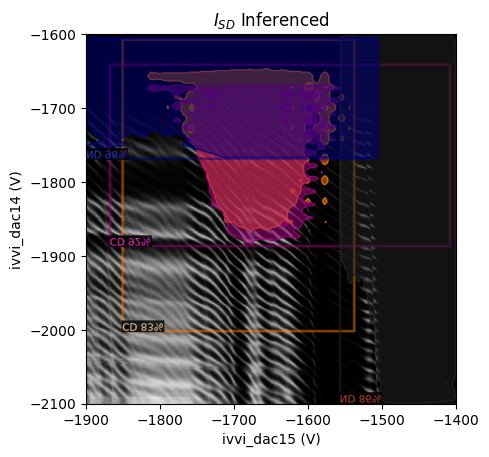

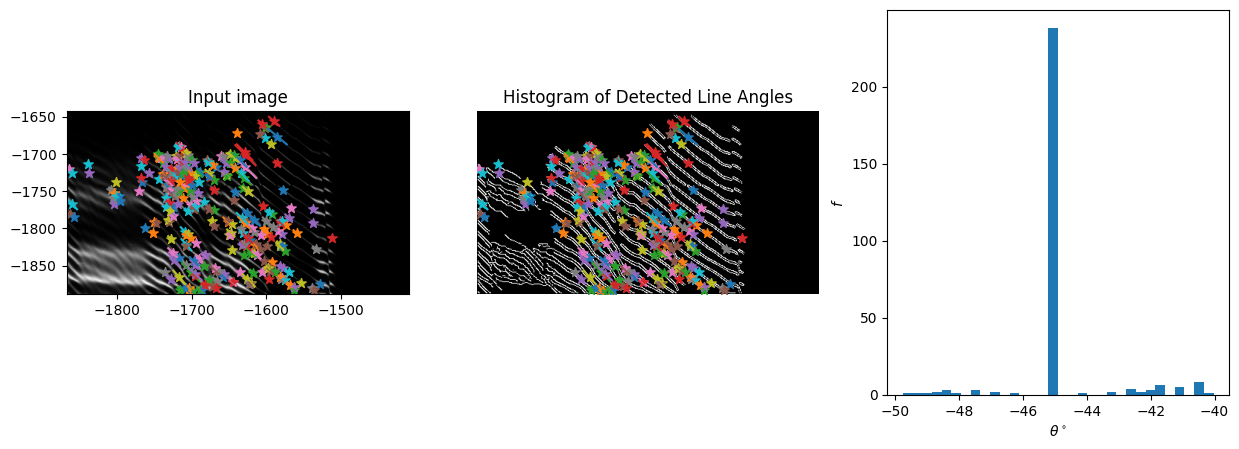

In [3]:
bp, voltage_window = DA.extract_bias_point(
    df,
    plot_process=True,
    axes=current_axes
)

# Coulomb Blockade

In [ ]:
df, axes = QD_FET_Tuner.coulomb_blockade(
    P='P', 
    P_bounds=(0,0.75), 
    dV=0.05,
    voltage_configuration={'S': 0.005, 'LB': -0.55, 'RB': -0.7}, 
)

### 4.1 Extract $\underset{\tilde{V}_P}{\mathrm{argmax}}\ G_{SD}$

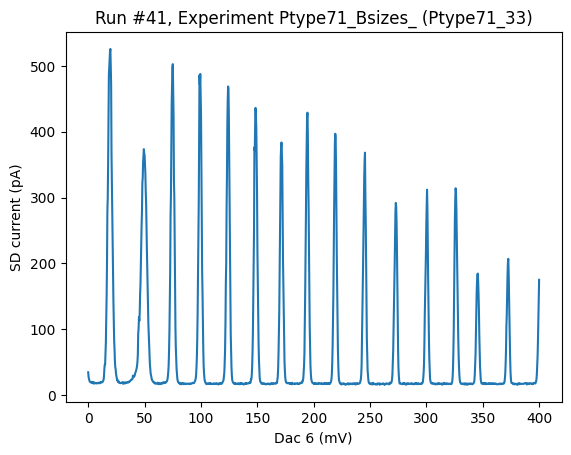

In [4]:
db_file = "/Users/andrijapaurevic/Desktop/db_20240517.db"

# runID_BB = 29
runID_CB = 41
import qcodes as qc
import sys, os
import matplotlib.pyplot as plt 

qc.dataset.initialise_or_create_database_at(db_file)

dataset = qc.dataset.load_by_id(runID_CB)
qc.dataset.plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()

0.10075062552126801 1.9227076248245416e-07


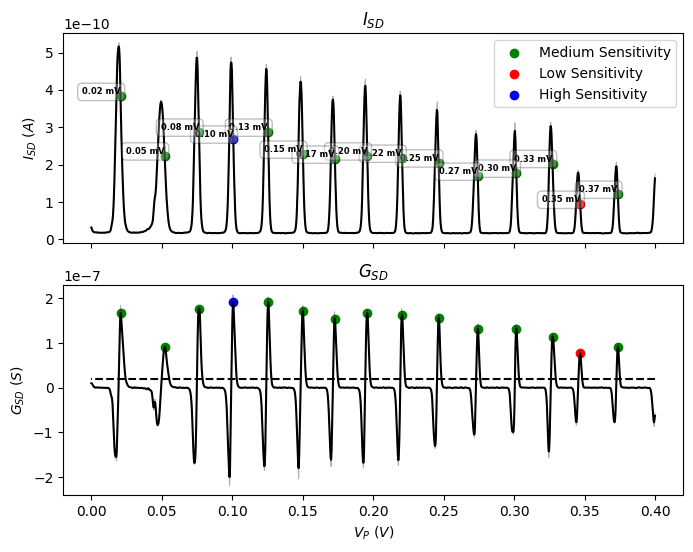

In [5]:
V_p, G_max = DA.extract_max_conductance_point(
    df,
    plot_process=True,
    sigma=1
)
print(V_p, G_max)

# 5. Coulomb Diamonds

In [ ]:
df, cd_axes = QD_FET_Tuner.coulomb_diamonds(
    ohmic='S', 
    gate='P', 
    ohmic_bounds=(-0.015, 0.015),
    gate_bounds=(0,0.75),
    dV_gate=0.03, 
    dV_ohmic=0.01,
    voltage_configuration={'LB': -0.55, 'RB': -0.7},
)

### 5.1 Extract lever arm, $\alpha$, at $\tilde{V}_{P}$

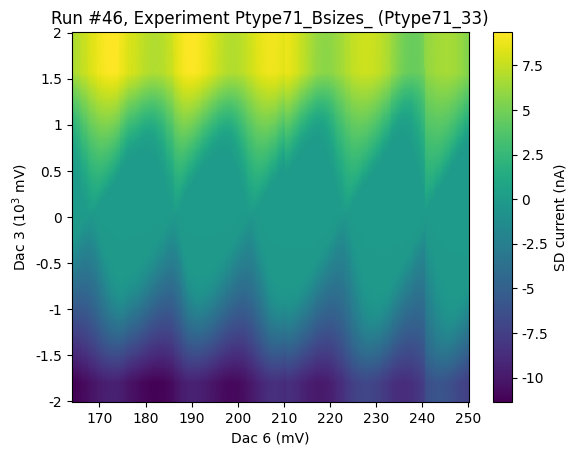

In [303]:
db_file = "/Users/andrijapaurevic/Desktop/db_20240517.db"

# runID_BB = 29
runID_CD = 46
import qcodes as qc
import sys, os
import matplotlib.pyplot as plt 

qc.dataset.initialise_or_create_database_at(db_file)

dataset = qc.dataset.load_by_id(runID_CD)
qc.dataset.plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()
df.iloc[:,0] = df.iloc[:,0].subtract(0).mul(1e-3) # sensitivity 
df.iloc[:,1] = df.iloc[:,1].subtract(0).mul(1e-3) # sensitivity 


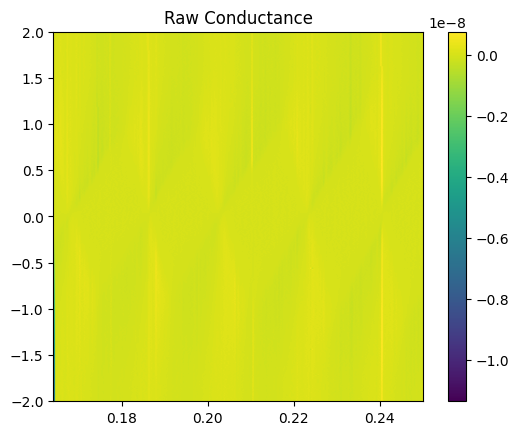

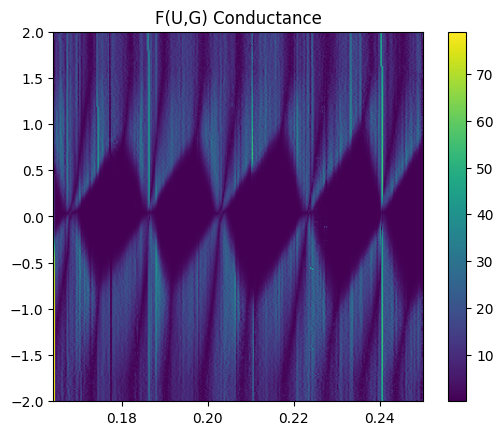

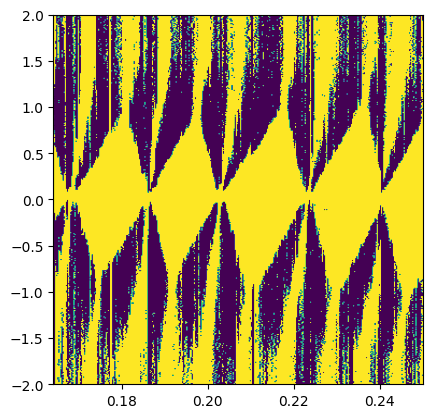

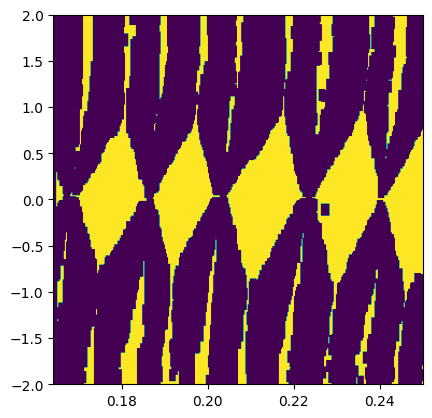

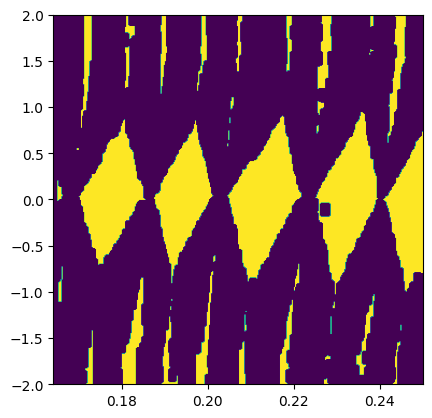

49 diamonds were detected.
{19: {'centroid': (0.23222036727879802, -0.050125313283210016), 'energy N': 0.014524207011685997, 'charging energy': 0.000786967418546366, 'lever arm': 0.05068747136658825}, 23: {'centroid': (0.1942821368948245, -0.0350877192982455), 'energy N': 0.013772954924874986, 'charging energy': 0.0009874686716792001, 'lever arm': 0.06798778555584446}, 24: {'centroid': (0.2130634390651085, 5.551115123125783e-16), 'energy N': 0.017278797996661016, 'charging energy': 0.0008822055137844615, 'lever arm': 0.06405346700083454}, 26: {'centroid': (0.17762938230384, 0.070175438596491), 'energy N': 0.015525876460768029, 'charging energy': 0.0008972431077694235, 'lever arm': 0.05192740304868477}}


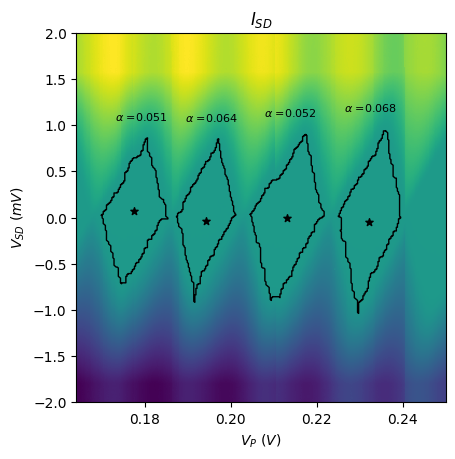

In [358]:
from scipy.ndimage import convolve
import numpy as np
import skimage.measure
import skimage.morphology
cond_quant = 3.25 * 1e-5
N=-6.7
G0 = 10**N * cond_quant

def U(x,y):
    sigX, sigY = 5,5
    return (1/(2 * np.pi * sigX * sigY)) * np.exp(- 0.5* ((x/sigX)**2 + (y/sigY)**2))
def adjusted(G,G0=G0):
    return np.sign(G) * np.log((np.abs(G)/G0) + 1)
def F(U, G,G0=G0):
    # G = adjusted(G,G0)
    return (G - convolve(G,U)) / np.sqrt((convolve(G,U))**2 + G0**2)

X_name, Y_name, Z_name = df.columns
Xdata, Ydata = np.unique(df[X_name]), np.unique(df[Y_name])

df_pivoted = df.pivot_table(values=Z_name, index=Y_name, columns=X_name).fillna(0)
Zdata = df_pivoted.to_numpy()


G = 0 * np.gradient(Zdata)[0] + np.gradient(Zdata)[1]

plt.imshow(G, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()], aspect=(Xdata.max() - Xdata.min())/(Ydata.max() - Ydata.min()))
plt.title("Raw Conductance")
plt.colorbar()

plt.show()


N=2
U_kernal = np.array([[U(x, y) for y in range(-(N-1)//2,(N-1)//2 + 1)] for x in range(-(N-1)//2,(N-1)//2 + 1)])

filtered_G = np.abs(F(U_kernal, G))
plt.imshow(filtered_G, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()], aspect=(Xdata.max() - Xdata.min())/(Ydata.max() - Ydata.min()))
plt.title("F(U,G) Conductance")
plt.colorbar()

plt.show()


import skimage
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.measure import find_contours#Load the image

#Denoise the image
denoised_image = gaussian(filtered_G, sigma=0.)

thresh = threshold_otsu(denoised_image)
binary_image = denoised_image < thresh

plt.imshow(binary_image, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()], aspect=(Xdata.max() - Xdata.min())/(Ydata.max() - Ydata.min()))
plt.show()

from skimage.morphology import erosion, dilation, opening, closing, white_tophat  # noqa
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import diamond, disk, rectangle  # noqa

footprint = rectangle(13, 6)

erode = skimage.morphology.erosion(binary_image,footprint)
plt.imshow(erode, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()], aspect=(Xdata.max() - Xdata.min())/(Ydata.max() - Ydata.min()))
plt.show()

footprint = diamond(1)
erode = skimage.morphology.erosion(erode,footprint)
plt.imshow(erode, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()], aspect=(Xdata.max() - Xdata.min())/(Ydata.max() - Ydata.min()))
plt.show()

# edges = canny(binary_image,sigma=1)

# Find contours at a constant value of 0.8
contours = skimage.measure.find_contours(erode, 0.8)
print('{} diamonds were detected.'.format(len(contours)))
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(Zdata, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()], aspect=(Xdata.max() - Xdata.min())/(Ydata.max() - Ydata.min()))
ax.set_title(r'$I_{SD}$')
ax.set_ylabel(r'$V_{SD}\ (mV)$')
ax.set_xlabel(r'$V_{P}\ (V)$')

EN = []
EC = []
CD_info = {}
for i, contour in enumerate(contours):
    if len(contour) < 350: 
        continue
    image_units = []
    for coordinate in contour:
        image_units.append([Ydata[int(coordinate[0])], Xdata[int(coordinate[1])]])
    image_units = np.array(image_units)
    
    Y = image_units[:,0]
    X = image_units[:,1]

    Xmax = max(X)
    Xmin = min(X)
    Ymax = max(Y)
    Ymin = min(Y)

    centroidX, centroidY = 0.5*(Xmax + Xmin), 0.5 * (Ymax + Ymin)

    EN += [Xmax - Xmin]
    EC += [(dY * divider /2)]
    CD_info[i]= {
        'centroid': (centroidX, centroidY), 
        'energy N': Xmax - Xmin, 
        'charging energy': (dY * divider /2), 
        'lever arm': (dY * divider /2) / dX
        }
    dX = Xmax - Xmin
    dY = Ymax - Ymin

    divider = 1e-3
    alpha= (dY * divider /2) / dX

    ax.plot(image_units[:, 1], image_units[:, 0], linewidth=1, linestyle='-', c='k')
    label_text = r'$\alpha$ =' + str(round(alpha,3))
    ax.text(0.975*centroidX, 1.2 * Ymax, label_text, color='k', fontsize=8, verticalalignment='bottom')
    ax.scatter([centroidX], [centroidY], marker='*', s=30, c='k')

print(CD_info)

In [ ]:
alpha = QD_FET_Tuner.DataAnalyzer.extract_lever_arms(
    df,
    plot_process=True,
    axes=cd_axes
)
print(V_p, G_max)

# Current Trace

In [ ]:
QD_FET_Tuner.current_trace(
    f_sampling=1000,
    t_capture=60, 
    plot_psd=True
)

# Ground Device

In [ ]:
QD_FET_Tuner.ground_device()

# DATABASE VIEWER

In [ ]:
db_file = "/Users/andrijapaurevic/Desktop/experiments_N44_D54_2024-05-08.db"
# import IPython.lib.backgroundjobs as bg
# from plottr.apps import inspectr

# jobs = bg.BackgroundJobManager()
# jobs.new(inspectr.main, db_file)

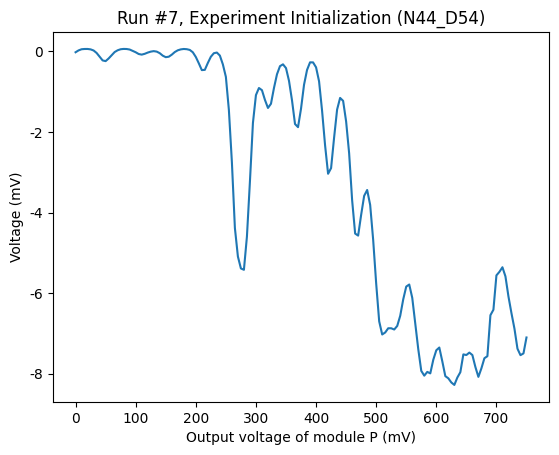

In [6]:
db_file = "/Users/andrijapaurevic/Desktop/experiments_N44_D54_2024-05-08.db"


import qcodes as qc


import sys, os
import matplotlib.pyplot as plt 
qc.dataset.initialise_or_create_database_at(db_file)
tutorial_exp = qc.dataset.load_or_create_experiment(
    experiment_name="Initialization",
    sample_name="N44_D54"
)

dataset = qc.dataset.load_by_run_spec(experiment_name='Initialization', captured_run_id=7)
qc.dataset.plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()


In [ ]:
import skimage
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data
import matplotlib.cm as cm


range_RB = (0.615,0.747)
range_LB = (0.533,0.631)
filtered_df = df[
    (df['sim900_volt_RB'] >= range_RB[0]) & (df['sim900_volt_RB'] <= range_RB[1]) &
    (df['sim900_volt_LB'] >= range_LB[0]) & (df['sim900_volt_LB'] <= range_LB[1])
]

cropped_img, Xdata, Ydata = convert_data_to_image(filtered_df)
cropped_img = cropped_img[:,:,0]
edges = canny(cropped_img,sigma=0.5, low_threshold=0.1*np.iinfo(np.uint8).max, high_threshold=0.3 * np.iinfo(np.uint8).max)
lines = probabilistic_hough_line(edges, threshold=0, line_length=3,
                                 line_gap=0)
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(cropped_img, cmap=cm.gray, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray, origin='lower',  extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
ax[1].set_title('Masked Canny edges')

potential_points = {}
angles_data = []
slopes_data = []
for line in lines:
    p0_pixel, p1_pixel = line
    p0, p1 = pixel_polygon_to_image_units(line, filtered_df)

    dy =  (p1[1]-p0[1])
    dx = (p1[0]-p0[0])
    if dx == 0:
        continue
    m = dy/dx
    theta = np.arctan(m)*(180/np.pi)
    if theta > -40 or theta < -60:
        continue
    angles_data.append(theta)
    slopes_data.append(m)
    midpoint_pixel = (np.array(p0_pixel) + np.array(p1_pixel))/2
    midpoint_units = (np.array(p0) + np.array(p1))/2
    # print(midpoint)
    midpoint = midpoint.astype(int)
    current_at_midpoint = filtered_df['agilent_volt'].to_numpy().reshape(len(Xdata), len(Ydata))[midpoint[0],midpoint[1]]
    potential_points[tuple(midpoint_units)] = current_at_midpoint

    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[1].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
    ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[0].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
    
# ax[1].set_xlim((0, cropped_img.shape[1]))
# ax[1].set_ylim((cropped_img.shape[0], 0))
ax[1].set_title('Probabilistic Hough')
ax[2].hist(angles_data, bins=2*int(np.sqrt(len(slopes_data))))
ax[2].set_xlabel(r"$\theta^\circ$")
ax[2].set_ylabel(r"$f$")
# ax[2].hist(angles_data)
# ax[0].set_axis_off()
ax[1].set_axis_off()

In [ ]:
print(potential_points)
max_key = np.array(max(potential_points, key=potential_points.get))
print("Key with the highest value:", max_key)
bias_point = {Xdata.name: max_key[0], Ydata.name: max_key[1]}
I = filtered_df['agilent_volt'].to_numpy().reshape(len(Ydata), len(Xdata))
plt.imshow(I, extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],origin='lower')
plt.scatter(*max_key, marker='*', c='r')
plt.ylabel(Ydata.name)
plt.xlabel(Xdata.name)
plt.colorbar()
plt.show()


print(f"Bias point: {bias_point}")